<div class="alert alert-block alert-info">
⚠️All notebooks should start with the following cell ⚠️.
<br>
<br>
This will ensure that the notebook is set in the correct working directory and that all internal modules can be loaded without setting an entry point.
</div>

In [176]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /workspaces/fil-rouge-pollinisateurs
Current working directory:  /workspaces/fil-rouge-pollinisateurs
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup notebook

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [178]:
path = "data/temporary_data/spipoll.csv"

In [179]:
data = pd.read_csv(path)

/tmp/ipykernel_1088/822284616.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


In [180]:
data.head(2)

,collection_id,protocole_long,user_id,plante_sc,plante_fr,plante_precision,plante_inconnue,plante_caractere,photo_fleur,photo_plante,...,insecte_fr,insecte_denominationPlusPrecise,insecte_CdNomtaxref,insecte_abondance,insecte_commentaire,insecte_vu_sur_fleur,nb_validation,nb_suggestion,latitude,longitude
0,1,NaN,12 657,Les Trèfles à fleurs blanches ou roses en boul...,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,...,L'Abeille mellifère,NaN,NaN,plus de 5,NaN,0.0,3.0,NaN,45.363808,6.514947
1,1,NaN,12 657,Les Trèfles à fleurs blanches ou roses en boul...,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,...,Les Bourdons noirs à bande(s) jaune(s) et cul ...,NaN,NaN,1,NaN,0.0,3.0,NaN,45.363808,6.514947


In [181]:
data.columns

Index(['collection_id', 'protocole_long', 'user_id', 'plante_sc', 'plante_fr',
       'plante_precision', 'plante_inconnue', 'plante_caractere',
       'photo_fleur', 'photo_plante', 'photo_feuille', 'code_postal',
       'habitat', 'grande_culture', 'collection_date',
       'collection_heure_debut', 'nebulosite', 'temperature', 'vent',
       'fleur_ombre', 'insecte_sc', 'insecte_fr',
       'insecte_denominationPlusPrecise', 'insecte_CdNomtaxref',
       'insecte_abondance', 'insecte_commentaire', 'insecte_vu_sur_fleur',
       'nb_validation', 'nb_suggestion', 'latitude', 'longitude'],
      dtype='object')

In [182]:
restricted_vars = [
    "collection_id",
    "plante_sc",
    "plante_fr",
    "insecte_sc",
    "insecte_fr",
    "temperature",
    "vent",
    "latitude",
    "longitude",
    "nebulosite",
    "collection_heure_debut",
]
df = data[restricted_vars].copy()

# Mise en place du modèle



## Pipeline de modélisation

In [183]:
df = data[restricted_vars].copy().sample(frac=1, random_state=1)
df.shape
df_transformed = df.copy()

On pourrait décider de n'entrainer le modèle que sur certaines heures, ou mois !


In [184]:
from models.supervised.preprocessors import get_df_by_hours, get_df_by_months

hour_range = [i for i in range(19, 25)]

df_transformed = get_df_by_hours(df_transformed, "collection_heure_debut", hour_range)
# df_transformed = get_df_by_months(df_transformed, "collection_heure_debut", [6, 7, 8])

In [185]:
from models.supervised.preprocessors import MetricsCalculatorNaive as MetricsCalculator

# Add the target variable to the dataframe

distance = 0.5
calculator = MetricsCalculator(distance=distance, clear_intermediate_steps=False)
calculator.fit(df_transformed)
df_transformed = calculator.transform(df_transformed)

Calculating metrics...


 17%|█▋        | 665/3824 [00:00<00:01, 2222.10it/s]

100%|██████████| 3824/3824 [00:02<00:00, 1725.62it/s]


In [186]:
from models.supervised.preprocessors import HourToCos, DateToJulian

# Add hour to cos tranformation and date to julian day transformation
df_transformed = HourToCos(hour_col="collection_heure_debut").fit_transform(
    df_transformed
)
df_transformed = DateToJulian(date_col="collection_heure_debut").fit_transform(
    df_transformed
)

In [187]:
# check that all transformations have been applied
df_transformed.head(2)

,collection_id,plante_sc,plante_fr,insecte_sc,insecte_fr,temperature,vent,latitude,longitude,nebulosite,collection_heure_debut,specific_richness,density,collection_id_density,weighted_specific_richness,collection_heure_debut_cos,collection_heure_debut_julian
598612,66 980,Buddleja davidii,Le Buddléia de David,Lepidoptera,Les Lépidoptères difficiles à déterminer,20-30ºC,"faible, irrégulier",45.057073,4.511406,0-25%,2022-08-03 20:43:00.000,103,324,67,1.537313,0.652760,2.459795e+06
605196,67 556,Centaurea jacea,Centaurée jacée,Pentatomidae,Les Pentatomes,10-20ºC,nul,47.524861,-1.747201,0-25%,2022-08-23 19:51:00.000,85,228,27,3.148148,0.465615,2.459815e+06


In [188]:
df_transformed.columns

Index(['collection_id', 'plante_sc', 'plante_fr', 'insecte_sc', 'insecte_fr',
       'temperature', 'vent', 'latitude', 'longitude', 'nebulosite',
       'collection_heure_debut', 'specific_richness', 'density',
       'collection_id_density', 'weighted_specific_richness',
       'collection_heure_debut_cos', 'collection_heure_debut_julian'],
      dtype='object')

In [189]:
numeric_features = [
    "latitude",
    "longitude",
    "collection_heure_debut_cos",
    "collection_heure_debut_julian",
]

ordinal_features = ["vent", "nebulosite", "temperature"]

nominal_features = [
    "plante_fr",
    # ....
]

categorical_features = ordinal_features + nominal_features

used_features = numeric_features + ordinal_features + nominal_features

In [190]:
X = df_transformed[used_features]
y = df_transformed["weighted_specific_richness"]

In [191]:
X.head()

,latitude,longitude,collection_heure_debut_cos,collection_heure_debut_julian,vent,nebulosite,temperature,plante_fr
598612,45.057073,4.511406,0.652760,2.459795e+06,"faible, irrégulier",0-25%,20-30ºC,Le Buddléia de David
605196,47.524861,-1.747201,0.465615,2.459815e+06,nul,0-25%,10-20ºC,Centaurée jacée
635957,46.421708,0.873030,0.263031,2.460089e+06,nul,0-25%,10-20ºC,Sureau du Canada
35296,44.711534,4.567885,0.402747,2.458681e+06,"faible, irrégulier",25-50%,20-30ºC,NaN
645966,49.024918,1.894976,0.362438,2.460132e+06,nul,0-25%,20-30ºC,Berce des prés


Il FAUT gérer les données manquantes. Pour ça on va utiliser un KNN qui va chercher les observations les plus proches pour compléter les données manquantes !

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

In [192]:
# idée: utiliser un KNN modifié pour remplacer les données par les plus proches spatialement !

In [193]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from models.supervised.preprocessors import HourToCos, DateToJulian

numeric_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", KNNImputer(n_neighbors=5)),
    ]
)

# make a pipeline for the categorical features (that combines ordinal and nominal)
categorical_pipeline = Pipeline(
    steps=[
        (
            "encoding",
            ColumnTransformer(
                transformers=[
                    (
                        "ordinal",
                        Pipeline(
                            steps=[
                                ("imputer", SimpleImputer(strategy="most_frequent")),
                                ("encoder", OrdinalEncoder()),
                            ]
                        ),
                        ordinal_features,
                    ),
                    (
                        "nominal",
                        Pipeline(
                            steps=[
                                ("imputer", SimpleImputer(strategy="most_frequent")),
                                ("encoder", OneHotEncoder(handle_unknown="ignore")),
                            ]
                        ),
                        nominal_features,
                    ),
                ],
                remainder="drop",
            ),
        ),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ],
    remainder="drop",
)

estimator = RandomForestRegressor(random_state=1)

# estimator = LinearRegression()

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", estimator),
    ]
)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['latitude', 'longitude',
                                                   'collection_heure_debut_cos',
                                                   'collection_heure_debut_julian']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   ColumnTransformer(transformers=[('ordinal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     Si...rategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OrdinalEncoder())]),
                                                                                                    ['vent',
                                                                                                     'nebulosite',
                                                                                                     'temperature']),
                                                                                                   ('nominal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                    ['plante_fr'])]))]),
                                                  ['vent', 'nebulosite',
                                                   'temperature',
                                                   'plante_fr'])])),
                ('estimator', RandomForestRegressor(random_state=1))])

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [195]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['latitude', 'longitude',
                                                   'collection_heure_debut_cos',
                                                   'collection_heure_debut_julian']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   ColumnTransformer(transformers=[('ordinal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     Si...rategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OrdinalEncoder())]),
                                                                                                    ['vent',
                                                                                                     'nebulosite',
                                                                                                     'temperature']),
                                                                                                   ('nominal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                    ['plante_fr'])]))]),
                                                  ['vent', 'nebulosite',
                                                   'temperature',
                                                   'plante_fr'])])),
                ('estimator', RandomForestRegressor(random_state=1))])

In [196]:
pipe.predict(X_test)

array([ 3.14814815,  1.6875    ,  2.74193548,  1.61363636,  1.81944444,
        2.74193548,  4.46666667,  1.39583333,  3.35      ,  1.81944444,
        1.375     ,  1.61363636,  2.89510526,  3.28571429,  1.39583333,
        1.6875    ,  1.39583333,  1.875     ,  3.35      ,  3.35      ,
        3.35      ,  3.35      ,  3.17142857,  1.53731343,  3.93333333,
       14.5       ,  4.66666667,  4.71428571,  1.39583333,  1.6875    ,
        3.35      ,  5.625     ,  3.14814815,  1.53731343,  2.74193548,
        4.46666667,  3.17964286,  0.79069767,  4.43625   ,  5.5       ,
        0.79069767,  2.73684211,  1.6875    ,  1.39583333,  1.81944444,
       14.5       ,  1.75      ,  1.56060606,  3.28571429,  3.35      ,
        1.81944444, 10.        ,  1.81944444,  1.53731343,  1.81944444,
        2.75      ,  0.79069767,  5.5       ,  3.14814815,  2.73684211,
        5.625     ,  4.46666667,  1.875     ,  0.79069767,  1.6875    ,
        1.53731343,  4.84307692,  3.35      ,  2.73684211,  1.68

In [197]:
# make all the scores for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = pipe.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 score: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 0.01
Mean absolute error: 0.01
R2 score: 1.00


In [198]:
# Cluncky way to get feature importance, not prone to change !!!!

importance = pipe.named_steps["estimator"].feature_importances_
# use passthrough step to get the features names
feature_names = (
    pipe.named_steps["preprocessor"]
    .transformers_[1][1]
    .named_steps["encoding"]
    .get_feature_names_out(input_features=categorical_features)
)
feature_names = np.concatenate([numeric_features, feature_names])

feature_importance = pd.DataFrame(
    {"feature": feature_names, "importance": importance}
).sort_values("importance", ascending=False)
feature_importance

,feature,importance
1,longitude,3.203351e-01
0,latitude,2.848538e-01
3,collection_heure_debut_julian,1.301572e-01
70,nominal__plante_fr_Grande Marguerite,9.719055e-02
37,nominal__plante_fr_Cerfeuil penché,8.535280e-02
...,...,...
155,nominal__plante_fr_Sarriette des montagnes,0.000000e+00
105,nominal__plante_fr_Marjolaine bâtarde,0.000000e+00
157,nominal__plante_fr_Sauge de Jérusalem,0.000000e+00
127,nominal__plante_fr_Passiflore,0.000000e+00


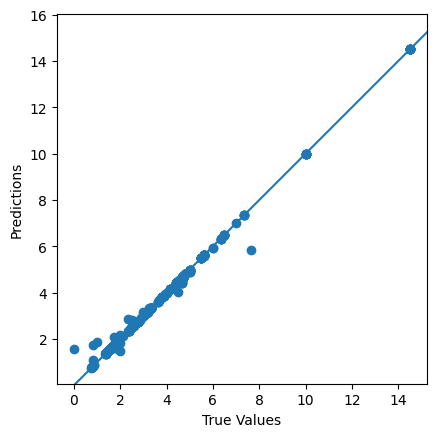

In [199]:
# plot y_test vs y_pred
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.axis("square")
_ = plt.plot([-100, 100], [-100, 100])

## Prediction sur carte France métropolitaine

In [200]:
france_data = pd.read_csv("data/temporary_data/france_place_modele.csv", sep=";")
france_data = france_data.sample(frac=0.1, random_state=1)

In [201]:
france_data.rename(
    columns={
        "lat": "latitude",
        "long": "longitude",
    },
    inplace=True,
)

In [202]:
# create columns if not existent from used_features

for col in used_features:
    if col not in france_data.columns:
        france_data[col] = np.nan

In [203]:
france_data = france_data[used_features]

In [204]:
france_data[used_features]
france_data["results"] = pipe.predict(france_data[used_features])

/tmp/ipykernel_1088/1752008247.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


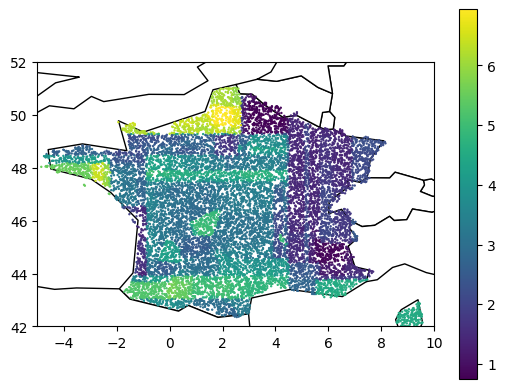

In [205]:
# plot the predictions in france map with the data knowing that france_data has lat and long
# use a map contour  
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming your DataFrame is named df and has columns "latitude", "longitude", and "results"
gdf = gpd.GeoDataFrame(france_data, geometry=gpd.points_from_xy(france_data.longitude, france_data.latitude))

# Load the map of France
france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france_boundary = france.unary_union

# Plot the map of France
ax = france.plot(color='white', edgecolor='black')

# Plot the results on the map
gdf.plot(ax=ax, column='results', legend=True, markersize=0.5)

# Set the bounding box to focus on France
ax.set_xlim(-5, 10)  # Longitude limits for France
ax.set_ylim(42, 52)  # Latitude limits for France


# Show the plot
plt.show()



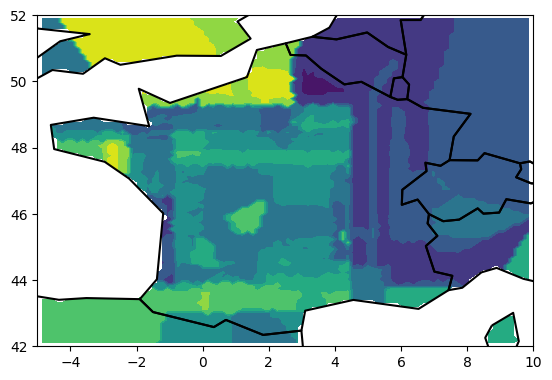

In [206]:
from shapely.geometry import box, Point
from scipy.interpolate import griddata

# Define the grid for interpolation
x = gdf['longitude']
y = gdf['latitude']
z = france_data['results']

# Create a grid of points within the bounding box of France
x_grid, y_grid = np.mgrid[-5:10:100j, 42:52:100j]

# Interpolate the data values on the grid
z_grid = griddata((x, y), z, (x_grid, y_grid), method='nearest')

# Get the boundary of metropolitan France
france_boundary = france.unary_union

# Create a bounding box for metropolitan France
bbox = box(minx=-5, miny=42, maxx=10, maxy=52)

# Create the mask for metropolitan France
mask = bbox.intersection(france_boundary)

# Create individual points for the mask
points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
mask_values = np.array([mask.contains(Point(p)) for p in points])
mask_values = mask_values.reshape(x_grid.shape)

# Apply the mask to the interpolated data and plot
masked_data = np.where(mask_values, z_grid, np.nan)
plt.contourf(x_grid, y_grid, masked_data, cmap='viridis')

france.boundary.plot(ax=plt.gca(), color='black')
# Set the bounding box to focus on France
plt.xlim(-5, 10)  # Longitude limits for France
plt.ylim(42, 52)  # Latitude limits for France


# Show the plot
plt.show()